In [111]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF

transform_hr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256)
])

transform_lr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128),
])

# random crop
def random_crop(img, crop_size):
    h, w = img.shape[:2]
    top = np.random.randint(0, h - crop_size)
    left = np.random.randint(0, w - crop_size)
    img = img[top:top+crop_size, left:left+crop_size]
    return img

class MyDataset(Dataset):
    def __init__(self, directory_path, downgrading_method=None):
        # get all file names in the directory
        self.directory_path = directory_path
        self.file_list = os.listdir(directory_path)
        self.downgrading_method = downgrading_method

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        # Return the data and target at the given index
        img_hr = cv2.imread(os.path.join(self.directory_path, self.file_list[index]))
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        img_hr = cv2.resize(img_hr, (256,256))
        
        if self.downgrading_method is None:
            img_lr = cv2.resize(img_hr, (img_hr.shape[1] // 2, img_hr.shape[0] // 2), interpolation=cv2.INTER_AREA)
        else:
            img_lr = self.downgrading_method(img_hr)
            
        return transform_hr(img_hr), transform_lr(img_lr)

datasets = MyDataset('/Users/terry/Desktop/WorldStrat_hr')

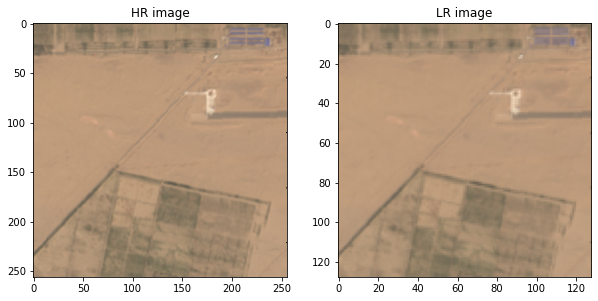

In [113]:
# example: datasets[0] -> (HR image, LR image)
def visualize_dataset(dataset):
    image_hr = dataset[0].permute(1, 2, 0).numpy()
    image_lr = dataset[1].permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image_hr)
    ax[0].set_title('HR image')

    ax[1].imshow(image_lr)
    ax[1].set_title('LR image')

    plt.show()

visualize_dataset(datasets[2])


In [100]:
from models.network_swinir import SwinIR

upscale = 4
window_size = 8
height = (500 // upscale // window_size + 1) * window_size
width = (500 // upscale // window_size + 1) * window_size
model = SwinIR(upscale=2, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')



In [104]:
from torch.utils.data import DataLoader

train_loader = DataLoader(datasets, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


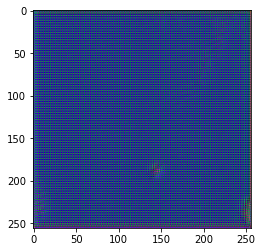

In [108]:
for batch in train_loader:
    hr, lr = batch
    res = model(lr)
    plt.imshow(res[0].detach().permute(1, 2, 0).numpy())
    break

In [110]:
from tqdm import tqdm

loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(100):
    total_loss = 0
    for batch in tqdm(train_loader):
        hr, lr = batch
        optimizer.zero_grad()
        res = model(lr)
        l = loss(res, hr)
        l.backward()
        optimizer.step()
        total_loss += l.item()
    print(f'epoch: {epoch}, loss: {total_loss / len(train_loader)}')


 39%|███▉      | 702/1799 [40:30<1:03:17,  3.46s/it]  


KeyboardInterrupt: 